In [87]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

## Importing the data

Importing the data, changing the labels to sentiment labels and balancing the training data

In [88]:
#specify CSV path
csv_path = '../Preprocessing/data_tokenized_BoW.csv'

#creating a df from the file
data = pd.read_csv(csv_path)

data.head(5)

,text,rating_overall
0,"['room', 'fine', 'service', 'try', 'hard', 'al...",3.0
1,"['best', 'place', 'stay', 'nyc', 'want', 'go',...",5.0
2,"['great', 'place', 'ill', 'always', 'check', '...",5.0
3,"['hotel', 'biggest', 'room', 'manhattan', 'lig...",5.0
4,"['want', 'stay', 'upper', 'west', 'side', 'nic...",4.0


In [89]:
data['rating_overall'] = data['rating_overall'].replace(range(0, 3), 'Negative')
data['rating_overall'] = data['rating_overall'].replace(3, 'Neutral')
data['rating_overall'] = data['rating_overall'].replace(range(4, 6), 'Positive')

result = data.groupby('rating_overall').size()

result

rating_overall
Negative     3263
Neutral      3982
Positive    38291
dtype: int64

### Building a document term matrix

In [90]:
words=data['text'].str.split(expand=True).stack().value_counts()
words

'room',                   20765
'hotel',                  18205
'great',                  15536
'staff',                  13958
'location',               12550
                          ...  
'doormengreat',               1
'touchsmooth',                1
'newthe',                     1
'cleanspaciousmodern',        1
'disregard']                  1
Name: count, Length: 29925, dtype: int64

In [91]:
word_freq = {}
for word in words:
    if word in word_freq:
        word_freq[word] += 1
    else:
        word_freq[word] = 1

print(word_freq)

{20765: 1, 18205: 1, 15536: 1, 13958: 1, 12550: 1, 10184: 1, 8275: 1, 8257: 1, 8096: 1, 7621: 1, 7478: 1, 6805: 1, 6177: 1, 5958: 1, 5256: 1, 4775: 1, 4558: 1, 4553: 1, 4134: 1, 3835: 1, 3666: 1, 3595: 1, 3458: 1, 3321: 2, 3295: 1, 3270: 1, 3230: 1, 2973: 1, 2596: 1, 2364: 1, 2328: 1, 2255: 1, 2169: 1, 2148: 1, 2140: 1, 2072: 1, 1957: 1, 1951: 1, 1921: 1, 1913: 1, 1850: 1, 1834: 1, 1833: 1, 1760: 1, 1749: 1, 1746: 1, 1718: 1, 1709: 1, 1687: 1, 1668: 1, 1666: 1, 1568: 1, 1560: 1, 1556: 1, 1530: 1, 1512: 1, 1484: 1, 1480: 1, 1468: 1, 1464: 1, 1463: 1, 1452: 1, 1421: 1, 1410: 1, 1408: 1, 1372: 2, 1350: 1, 1349: 1, 1342: 1, 1327: 1, 1306: 1, 1290: 1, 1279: 1, 1254: 1, 1236: 1, 1223: 1, 1216: 1, 1200: 1, 1182: 1, 1172: 1, 1165: 1, 1155: 1, 1148: 1, 1108: 1, 1107: 1, 1077: 1, 1070: 1, 1063: 1, 1050: 1, 1046: 1, 1040: 1, 1029: 1, 1027: 1, 1014: 1, 1010: 1, 997: 1, 994: 1, 988: 1, 980: 1, 968: 1, 961: 1, 939: 1, 930: 1, 925: 1, 905: 2, 870: 1, 868: 1, 865: 1, 863: 1, 856: 1, 848: 1, 847: 2, 84

In [92]:
def build_document_term_matrix(data):
    """
    Builds a Bag-of-Words document-term matrix.
    Returns:
    - document_term_matrix (list of lists): BoW representation of documents
    - vocab (list): Sorted vocabulary of unique words
    - word_to_index (dict): Mapping of word → index in vocabulary
    """
    # 1. Extract unique vocabulary from the dataset and sort it
    # Get all unique words from the 'text' column of the DataFrame
    vocab = sorted(set(word for doc in data['text'] for word in doc.split())) 
    
    # 2. Create a word-to-index mapping
    word_to_index = {word: idx for idx, word in enumerate(vocab)}

    print(word_to_index)

    # 3. Convert each document into a vector
    document_term_matrix = []
    
    # Iterate through the 'text' column of the DataFrame
    for doc in data['text']:
        doc_vector = [0] * len(vocab)  # Initialize a vector of zeros
        for token in doc.split(): # Split the document into tokens
            if token in word_to_index:
                doc_vector[word_to_index[token]] += 1  # Increment word count
        document_term_matrix.append(doc_vector)

    print(f"\nVocabulary Size: {len(vocab)} | Number of Documents: {len(document_term_matrix)}\n")
    # Print vectors for first two sentences 
    for i, vector in enumerate(document_term_matrix[:2]):
        print(f"Document {i} vector:\n{vector}\n")
        # Access the document text using .iloc to get the row by index
        print(f"Document {i} text:\n{data['text'].iloc[i]}\n\n{'#'*50}\n") 

    # Optionally, we can inspect the shape of our document-term matrix
    print(f"Number of documents: {len(document_term_matrix)}")
    print(f"Vocabulary size: {len(vocab)}")

    return document_term_matrix, vocab, word_to_index

document_term_matrix, vocab, word_to_index = build_document_term_matrix(data)



{"'": 0, "',": 1, "'0',": 2, "'0']": 3, "'00am',": 4, "'01',": 5, "'01082011',": 6, "'02',": 7, "'0200',": 8, "'0202',": 9, "'022004',": 10, "'03',": 11, "'0330',": 12, "'04',": 13, "'042012',": 14, "'042905',": 15, "'0430',": 16, "'043005',": 17, "'05',": 18, "'0500',": 19, "'06',": 20, "'0600',": 21, "'060512',": 22, "'060612',": 23, "'06222012',": 24, "'07',": 25, "'0700',": 26, "'0700am',": 27, "'08',": 28, "'08']": 29, "'09',": 30, "'0907',": 31, "'1',": 32, "'1']": 33, "'10',": 34, "'10']": 35, "'100',": 36, "'100']": 37, "'1000',": 38, "'1000']": 39, "'10000',": 40, "'100150',": 41, "'1003',": 42, "'1004',": 43, "'1005',": 44, "'100amnot',": 45, "'100if',": 46, "'100lobby',": 47, "'100night',": 48, "'100room',": 49, "'101',": 50, "'1010',": 51, "'101010',": 52, "'1012',": 53, "'1014',": 54, "'1015',": 55, "'1015']": 56, "'1015min',": 57, "'102',": 58, "'102412',": 59, "'102611',": 60, "'102711',": 61, "'103',": 62, "'1030',": 63, "'1030am',": 64, "'1030pmoff',": 65, "'104',": 66

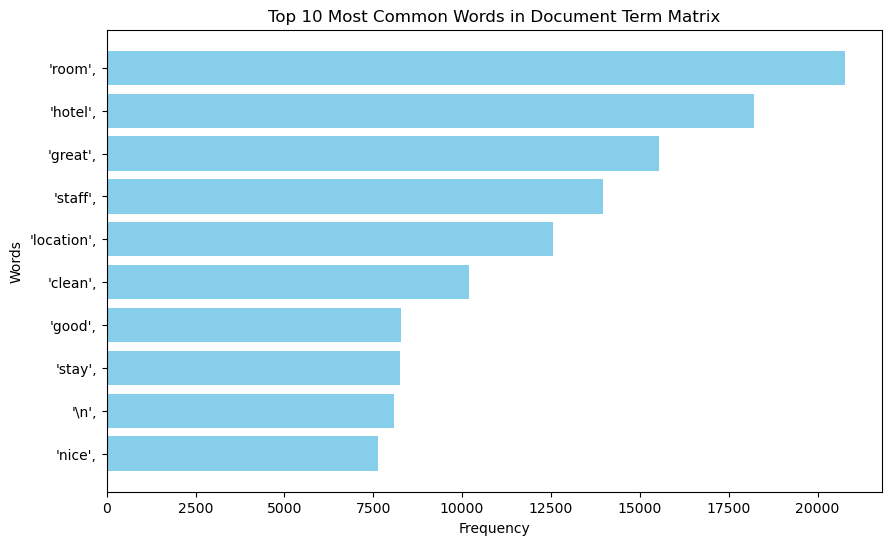

In [93]:

def visualize_top_n_tokens(n, document_term_matrix):

    # Sum the occurrences of each word across all documents
    word_counts = np.sum(document_term_matrix, axis=0)

    # Get the indices of the top n most common words
    top_n_indices = np.argsort(word_counts)[-n:]

    # Get the corresponding words and their counts
    top_n_words = [vocab[i] for i in top_n_indices]
    top_n_counts = word_counts[top_n_indices]

    # Create the bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_n_words, top_n_counts, color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title(f'Top {n} Most Common Words in Document Term Matrix')
    plt.show()

visualize_top_n_tokens(10, document_term_matrix)

## Building the BoW 

In [94]:
(
    
    X_train,
    X_rem,
    y_train,
    y_rem

) = train_test_split(data["text"], data["rating_overall"], train_size=0.9, random_state=42)

(X_valid, X_test, y_valid, y_test) = train_test_split(X_rem,y_rem, test_size=0.5)



In [95]:
# balancing the training set

from sklearn.utils import resample

# Combine X_train and y_train into a single DataFrame for resampling
train_data = pd.DataFrame({'text': X_train, 'rating_overall': y_train})

# Separate the classes in the training set using the correct labels
positive_data = train_data[train_data['rating_overall'] == 'Positive']
neutral_data = train_data[train_data['rating_overall'] == 'Neutral']
negative_data = train_data[train_data['rating_overall'] == 'Negative']

# Downsample the majority class (Positive) to match the size of the minority class (Neutral or Negative, whichever is larger)
minority_class_size = max(len(neutral_data), len(negative_data))  # Use max to find the larger minority class

positive_data_downsampled = resample(
    positive_data,
    replace=False,  # Do not sample with replacement
    n_samples=minority_class_size,  # Match the size of the larger minority class
    random_state=42  # For reproducibility
)

# Combine the downsampled majority class with the other classes
train_data_balanced = pd.concat([positive_data_downsampled, neutral_data, negative_data])

# Shuffle the balanced training data
train_data_balanced = train_data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate the balanced training data back into X_train and y_train
X_train = train_data_balanced['text']
y_train = train_data_balanced['rating_overall']

# Verify the class distribution in the balanced training set
print("Class distribution in the balanced training set:")
print(y_train.value_counts())

Class distribution in the balanced training set:
rating_overall
Positive    3560
Neutral     3560
Negative    2933
Name: count, dtype: int64


In [96]:
print(f"Train set: {len(X_train)} samples")
print(f"Valid set: {len(X_valid)} samples")
print(f"Test set: {len(X_test)} samples")

Train set: 10053 samples
Valid set: 2277 samples
Test set: 2277 samples


In [97]:
# countvectorizer
cv = CountVectorizer()
X_train_vectorized = cv.fit_transform(X_train)

X_train_vectorized.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], shape=(10053, 10616))

# Training and testing on different classifiers

### Logistical Regression

In [98]:
# Define pipeline
LR_pipeline = Pipeline([
    ('logreg', LogisticRegression()),
])


# Define parameters for grid search
LR_parameters = {
    'logreg__C': [0.1, 1.0, 10.0],
    'logreg__max_iter': [10000],
    'logreg__solver': ['saga'],
}


# Create grid search object
LR_grid_search = GridSearchCV(LR_pipeline, LR_parameters, scoring='f1_weighted', cv=5, n_jobs=-1)


# Fit the grid search to the training data
#grid_search.fit(X_train, y_train)
LR_grid_search.fit(X_train_vectorized, y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('logreg', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logreg__C': [0.1, 1.0, 10.0],
                         'logreg__max_iter': [10000],
                         'logreg__solver': ['saga']},
             scoring='f1_weighted')

In [99]:
X_val_vectorized = cv.transform(X_valid)

best_LR_model = LR_grid_search.best_estimator_
LR_y_pred = best_LR_model.predict(X_val_vectorized)

# Print best parameters and score
print("Best parameters: ", LR_grid_search.best_params_)
print("Best accuracy score: ", LR_grid_search.best_score_)


Best parameters:  {'logreg__C': 0.1, 'logreg__max_iter': 10000, 'logreg__solver': 'saga'}
Best accuracy score:  0.7235028637890208


In [100]:
print("Performance on the training set:")
print(classification_report(y_train, best_LR_model.predict(X_train_vectorized)))

print("Performance on the validation set:")
print(classification_report(y_valid, LR_y_pred))

Performance on the training set:
              precision    recall  f1-score   support

    Negative       0.86      0.84      0.85      2933
     Neutral       0.78      0.77      0.77      3560
    Positive       0.84      0.88      0.86      3560

    accuracy                           0.83     10053
   macro avg       0.83      0.83      0.83     10053
weighted avg       0.83      0.83      0.83     10053

Performance on the validation set:
              precision    recall  f1-score   support

    Negative       0.59      0.71      0.65       171
     Neutral       0.28      0.62      0.38       227
    Positive       0.97      0.80      0.88      1879

    accuracy                           0.78      2277
   macro avg       0.61      0.71      0.64      2277
weighted avg       0.87      0.78      0.81      2277



In [101]:
test_df_vectorized = cv.transform(X_test)

print("Performance on the test set:")
print(classification_report(y_test, best_LR_model.predict(test_df_vectorized)))

Performance on the test set:
              precision    recall  f1-score   support

    Negative       0.55      0.71      0.62       159
     Neutral       0.26      0.62      0.37       195
    Positive       0.97      0.81      0.88      1923

    accuracy                           0.79      2277
   macro avg       0.59      0.71      0.62      2277
weighted avg       0.88      0.79      0.82      2277



#### Exctracting feature importance

In [102]:
#Made with the help of AI

# Extract the Logistic Regression model from the pipeline
logreg_model = best_LR_model.named_steps['logreg']  # Replace 'logreg' with the name of your LogisticRegression step

# Get the feature names (words) from the CountVectorizer
feature_names = cv.get_feature_names_out()

# Get the coefficients of the Logistic Regression model
coefficients = logreg_model.coef_

# Get the class labels
class_labels = logreg_model.classes_

# Extract the top N words for each class
N = 20  # Number of top words to extract
for i, class_label in enumerate(class_labels):
    print(f"Top {N} words for class '{class_label}':")
    
    # Get the indices of the top N words for the current class
    top_indices = coefficients[i].argsort()[-N:][::-1]
    
    # Get the corresponding words and their weights
    top_words = [(feature_names[j], coefficients[i][j]) for j in top_indices]
    
    # Print the top words
    for word, weight in top_words:
        print(f"{word}: {weight:.4f}")
    print()

Top 20 words for class 'Negative':
bug: 0.9632
dirty: 0.9290
rude: 0.9226
poor: 0.8911
horrible: 0.8241
worst: 0.7832
filthy: 0.6713
terrible: 0.6702
awful: 0.6449
avoid: 0.5991
cockroach: 0.5926
dump: 0.5861
never: 0.5224
bedbug: 0.5180
unfriendly: 0.5029
bite: 0.4990
worse: 0.4804
checked: 0.4674
run: 0.4621
smelly: 0.4547

Top 20 words for class 'Neutral':
average: 1.0472
ok: 0.7576
okay: 0.6744
adequate: 0.5676
fine: 0.5141
otherwise: 0.4968
decent: 0.4939
frill: 0.4868
older: 0.4752
fancy: 0.4652
nothing: 0.4574
basic: 0.4262
typical: 0.4190
updating: 0.3455
compared: 0.3430
wear: 0.3394
age: 0.3345
bad: 0.3327
outlet: 0.3321
pressure: 0.3263

Top 20 words for class 'Positive':
excellent: 1.0042
wonderful: 0.8479
loved: 0.7923
fantastic: 0.7593
amazing: 0.7317
love: 0.7292
great: 0.7175
perfect: 0.7040
beautiful: 0.6916
enjoyed: 0.6769
awesome: 0.6612
modern: 0.6341
everything: 0.6141
exceptional: 0.5740
highly: 0.5691
lovely: 0.5196
best: 0.5140
beat: 0.5121
nice: 0.4945
quiet: 0

### Random Forest

In [103]:
# Define pipeline
RF_pipeline = Pipeline([
    ('rf', RandomForestClassifier()),
])


# Define parameters for grid search
RF_parameters = {
   'rf__criterion': ['gini', 'entropy', 'log_loss'],
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [60,70], #[10, 20, 30],
    'rf__min_samples_leaf':[5],
    'rf__class_weight':['balanced'],
}


# Create grid search object
RF_grid_search = GridSearchCV(RF_pipeline, RF_parameters, scoring='f1_weighted', cv=5, n_jobs=-1)


# Fit the grid search to the training data
#grid_search.fit(X_train, y_train)
RF_grid_search.fit(X_train_vectorized, y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__class_weight': ['balanced'],
                         'rf__criterion': ['gini', 'entropy', 'log_loss'],
                         'rf__max_depth': [60, 70], 'rf__min_samples_leaf': [5],
                         'rf__n_estimators': [100, 200, 300]},
             scoring='f1_weighted')

In [104]:
best_RF_model = RF_grid_search.best_estimator_
RF_y_pred = best_RF_model.predict(X_val_vectorized)

# Print best parameters and score
print("Best parameters: ", RF_grid_search.best_params_)
print("Best accuracy score: ", RF_grid_search.best_score_)

Best parameters:  {'rf__class_weight': 'balanced', 'rf__criterion': 'gini', 'rf__max_depth': 70, 'rf__min_samples_leaf': 5, 'rf__n_estimators': 300}
Best accuracy score:  0.6941337031979862


In [105]:
print("Performance on the training set:")
print(classification_report(y_train, best_RF_model.predict(X_train_vectorized)))

print("Performance on the validation set:")
print(classification_report(y_valid, RF_y_pred))

Performance on the training set:


              precision    recall  f1-score   support

    Negative       0.74      0.82      0.78      2933
     Neutral       0.73      0.56      0.63      3560
    Positive       0.74      0.84      0.79      3560

    accuracy                           0.74     10053
   macro avg       0.74      0.74      0.73     10053
weighted avg       0.74      0.74      0.73     10053

Performance on the validation set:
              precision    recall  f1-score   support

    Negative       0.50      0.77      0.61       171
     Neutral       0.28      0.48      0.35       227
    Positive       0.95      0.82      0.88      1879

    accuracy                           0.78      2277
   macro avg       0.58      0.69      0.61      2277
weighted avg       0.85      0.78      0.81      2277



In [106]:
print("Performance on the test set:")
print(classification_report(y_test, best_RF_model.predict(test_df_vectorized)))

Performance on the test set:
              precision    recall  f1-score   support

    Negative       0.48      0.80      0.60       159
     Neutral       0.27      0.50      0.35       195
    Positive       0.96      0.82      0.89      1923

    accuracy                           0.79      2277
   macro avg       0.57      0.71      0.61      2277
weighted avg       0.87      0.79      0.82      2277



Extracting feature importance

In [108]:
#MAde with the hlp of AI

# Extract the Random Forest model from the pipeline
rf_model = best_RF_model.named_steps['rf']  # Replace 'randomforest' with the actual step name in your pipeline

# Get feature importance from the Random Forest model
feature_importance = rf_model.feature_importances_

# Get the feature names from the TF-IDF vectorizer
feature_names = cv.get_feature_names_out()

# Combine feature names with their importance
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Sort features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Display the top N most important features
N = 20  # Number of top features to display
print(f"Top {N} most important features:")
for feature, importance in sorted_features[:N]:
    print(f"{feature}: {importance:.4f}")

Top 20 most important features:
great: 0.0771
dirty: 0.0323
staff: 0.0257
excellent: 0.0249
location: 0.0242
clean: 0.0237
friendly: 0.0216
nice: 0.0211
wonderful: 0.0209
good: 0.0202
rude: 0.0179
average: 0.0162
never: 0.0162
bug: 0.0162
worst: 0.0154
ok: 0.0149
helpful: 0.0148
comfortable: 0.0144
perfect: 0.0130
loved: 0.0119


### MLP

In [109]:
# Define pipeline
MLP_pipeline = Pipeline([
    ('svd', TruncatedSVD(n_components=100)),  # Dimensionality reduction
    ('scaler', StandardScaler(with_mean=False)),  # Scaling
    ('mlp', MLPClassifier()),  # Classifier
])

In [110]:
MLP_parameters = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (150,), (200,)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__solver': ['adam', 'sgd'],
    'mlp__alpha': [0.0001, 0.001, 0.01],  # Regularization strength
}

In [111]:

MLP_grid_search = GridSearchCV(MLP_pipeline, MLP_parameters, scoring='f1_weighted', cv=5, n_jobs=-1)

# Fit the grid search to the training data
MLP_grid_search.fit(X_train_vectorized, y_train)

/opt/anaconda3/envs/aiml25-ma3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/aiml25-ma3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/aiml25-ma3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/aiml25-ma3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('svd', TruncatedSVD(n_components=100)),
                                       ('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('mlp', MLPClassifier())]),
             n_jobs=-1,
             param_grid={'mlp__activation': ['relu', 'tanh'],
                         'mlp__alpha': [0.0001, 0.001, 0.01],
                         'mlp__hidden_layer_sizes': [(50,), (100,), (150,),
                                                     (200,)],
                         'mlp__solver': ['adam', 'sgd']},
             scoring='f1_weighted')

In [112]:
best_MLP_model = MLP_grid_search.best_estimator_
MLP_y_pred = best_MLP_model.predict(X_val_vectorized)

# Print best parameters and score
print("Best parameters: ", MLP_grid_search.best_params_)
print("Best accuracy score: ", MLP_grid_search.best_score_)

Best parameters:  {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (200,), 'mlp__solver': 'sgd'}
Best accuracy score:  0.7036445737094839


In [113]:
print("Performance on the training set:")
print(classification_report(y_train, best_MLP_model.predict(X_train_vectorized)))

print("Performance on the validation set:")
print(classification_report(y_valid, MLP_y_pred))

Performance on the training set:
              precision    recall  f1-score   support

    Negative       0.80      0.81      0.80      2933
     Neutral       0.73      0.70      0.72      3560
    Positive       0.81      0.83      0.82      3560

    accuracy                           0.78     10053
   macro avg       0.78      0.78      0.78     10053
weighted avg       0.78      0.78      0.78     10053

Performance on the validation set:
              precision    recall  f1-score   support

    Negative       0.50      0.70      0.58       171
     Neutral       0.25      0.59      0.35       227
    Positive       0.96      0.77      0.85      1879

    accuracy                           0.74      2277
   macro avg       0.57      0.68      0.59      2277
weighted avg       0.85      0.74      0.78      2277



In [114]:
print("Performance on the test set:")
print(classification_report(y_test, best_MLP_model.predict(test_df_vectorized)))

Performance on the test set:
              precision    recall  f1-score   support

    Negative       0.50      0.71      0.59       159
     Neutral       0.25      0.67      0.36       195
    Positive       0.96      0.77      0.86      1923

    accuracy                           0.76      2277
   macro avg       0.57      0.72      0.60      2277
weighted avg       0.87      0.76      0.79      2277

